In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import argparse
import os
import datetime
import matplotlib.pyplot as plt

## Define 2-Layer Neural Net

In [ ]:
# Define the two-layer neural network
class shallow_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(shallow_net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # First layer
        self.relu = nn.ReLU()  # Activation function
        self.fc2 = nn.Linear(hidden_size, output_size, bias=False)  # Second layer
        self.skip = nn.Linear(input_size, output_size, bias=True)  # Skip connection

    def forward(self, x):
        out = self.fc1(x)  # First layer
        out = self.relu(out)  # Activation function
        out = self.fc2(out)  # Second layer
        skip = self.skip(x)  # Skip connection
        out = out + skip  # Add the skip connection
        return out

## Train Net

In [16]:
def train_net(model, num_epochs, x_train, y_train, lr, lam):
    
    loss_arr = []
    pn_arr = []
    sparsity_neurons = []
    
    # Loss and optimizer
    criterion = nn.MSELoss()

    weight_params = []
    bias_params = []
    skip_params = []
    for name, param in model.named_parameters():
        if 'weight' in name:
            weight_params.append(param)
        elif 'bias' in name:
            bias_params.append(param)
        elif 'skip' in name:
            skip_params.append(param)
    
    optimizer = optim.Adam([
    {'params': weight_params},
    {'params': bias_params, 'weight_decay': 0},
    {'params': skip_params, 'weight_decay': 0}  # No weight decay for biases/skip
    ], lr=lr, weight_decay=lam)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        
        # Forward pass
        outputs = model(x_train)
        loss = criterion(outputs, y_train)

        loss_arr.append(loss.item())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        with torch.no_grad():
            # Compute path norm
            pn = torch.sum(torch.linalg.norm(model.fc1.weight, axis=1, ord=2) \
                           * torch.linalg.norm(model.fc2.weight[0:1], axis=0, ord=2))
            pn_arr.append(pn.item())


            # Sparsity PRIMARY TASK
            sparsity = torch.sum(torch.abs(model.fc2.weight[0]) > 1e-3)
            sparsity_neurons.append(sparsity.item())
            
            # Compute sum squr weights
            sum_sq_weights = 0
            for name, param in model.named_parameters():
                if 'weight' in name:
                    sum_sq_weights += torch.linalg.norm(param)**2

            bias_on = (torch.sum(model.fc1.bias > 0)).item()
            
                    
            if epoch % 100==0:

                print('Epoch [{}/{}], Loss: {:.3e}, PN: {:.3f},WD: {:.2f},Sparse Prime: {:d}'\
                      .format(epoch+1, num_epochs, loss.item(), \
                              pn.item(), sum_sq_weights.item()/2,\
                              sparsity.item()))

    return loss_arr, pn_arr, sparsity_neurons

## Make Dataset

In [17]:
xs = torch.as_tensor([[-1.5, -1, 0, 0.2, 2]]).T
ys = torch.as_tensor([[0.7, -0.5, -0.5, 0.5, 0.2]]).T

print('xs shape: {}'.format(xs.shape))
print('ys shape: {}'.format(ys.shape))

xs shape: torch.Size([5, 1])
ys shape: torch.Size([5, 1])


## Train Single Task

In [21]:
K = 10
torch.manual_seed(20)
sing_task_1 = shallow_net(1, K, 1).to('cuda:1')

lr = 1e-3
lam = 1e-4

epochs=10000

loss_arr_sing, pn_arr_sing, sparsity_neurons_sing = train_net(sing_task_1, epochs, \
                                                              xs.to('cuda:1'), ys.to('cuda:1'), lr, lam)

Epoch [1/10000], Loss: 3.275e-01, PN: 0.820,WD: 2.03,Sparse Prime: 10
Epoch [101/10000], Loss: 2.304e-01, PN: 0.811,WD: 2.01,Sparse Prime: 10
Epoch [201/10000], Loss: 2.029e-01, PN: 1.004,WD: 2.26,Sparse Prime: 10
Epoch [301/10000], Loss: 1.824e-01, PN: 1.287,WD: 2.54,Sparse Prime: 10
Epoch [401/10000], Loss: 1.598e-01, PN: 1.677,WD: 2.92,Sparse Prime: 9
Epoch [501/10000], Loss: 1.342e-01, PN: 2.197,WD: 3.43,Sparse Prime: 9
Epoch [601/10000], Loss: 1.083e-01, PN: 2.864,WD: 4.09,Sparse Prime: 9
Epoch [701/10000], Loss: 8.550e-02, PN: 3.633,WD: 4.87,Sparse Prime: 9
Epoch [801/10000], Loss: 6.761e-02, PN: 4.433,WD: 5.72,Sparse Prime: 9
Epoch [901/10000], Loss: 5.420e-02, PN: 5.224,WD: 6.59,Sparse Prime: 9
Epoch [1001/10000], Loss: 4.370e-02, PN: 5.988,WD: 7.46,Sparse Prime: 9
Epoch [1101/10000], Loss: 3.481e-02, PN: 6.726,WD: 8.32,Sparse Prime: 9
Epoch [1201/10000], Loss: 2.703e-02, PN: 7.441,WD: 9.17,Sparse Prime: 9
Epoch [1301/10000], Loss: 2.030e-02, PN: 8.137,WD: 9.99,Sparse Prime: 9


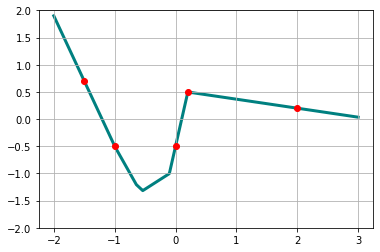

In [22]:
x_test = torch.linspace(-2, 3, 1000).reshape(1000, 1)
y_eval = sing_task_1(x_test.to('cuda:1')).detach().cpu()
plt.grid()
plt.scatter(xs, ys, color='red', zorder=1)
plt.plot(x_test, y_eval, color='teal', linewidth=3, zorder=-1)
plt.ylim([-2,2])
#plt.savefig('scalar_out_univ_fit_rand_1.pdf', dpi=500, bbox_inches='tight')
plt.show()

In [38]:
torch.save(x_test, 'figs_data/univar_fig/x_test.pt')
torch.save(y_eval, 'figs_data/univar_fig/y_eval_sing_1.pt')

In [ ]:
K = 10
torch.manual_seed(40)
sing_task_2 = shallow_net(1, K, 1).to('cuda:1')

lr = 1e-3
lam = 1e-4

epochs=10000

loss_arr_sing_2, pn_arr_sing_2, sparsity_neurons_sing_2 = train_net(sing_task_2, epochs, \
                                                              xs.to('cuda:1'), ys.to('cuda:1'), lr, lam)

Epoch [1/10000], Loss: 3.169e-01, PN: 1.056,WD: 1.85,Sparse Prime: 10
Epoch [101/10000], Loss: 1.585e-01, PN: 1.448,WD: 2.07,Sparse Prime: 10
Epoch [201/10000], Loss: 9.879e-02, PN: 2.807,WD: 3.58,Sparse Prime: 9
Epoch [301/10000], Loss: 6.166e-02, PN: 4.778,WD: 5.87,Sparse Prime: 9
Epoch [401/10000], Loss: 2.516e-02, PN: 7.527,WD: 9.11,Sparse Prime: 9
Epoch [501/10000], Loss: 5.615e-03, PN: 10.210,WD: 12.09,Sparse Prime: 9
Epoch [601/10000], Loss: 1.133e-03, PN: 11.538,WD: 13.36,Sparse Prime: 9
Epoch [701/10000], Loss: 4.886e-04, PN: 11.905,WD: 13.50,Sparse Prime: 9
Epoch [801/10000], Loss: 3.914e-04, PN: 11.974,WD: 13.30,Sparse Prime: 9
Epoch [901/10000], Loss: 3.743e-04, PN: 11.986,WD: 13.08,Sparse Prime: 9
Epoch [1001/10000], Loss: 3.675e-04, PN: 11.992,WD: 12.88,Sparse Prime: 9
Epoch [1101/10000], Loss: 3.588e-04, PN: 11.997,WD: 12.72,Sparse Prime: 9
Epoch [1201/10000], Loss: 3.506e-04, PN: 12.000,WD: 12.58,Sparse Prime: 9
Epoch [1301/10000], Loss: 3.404e-04, PN: 12.004,WD: 12.47,

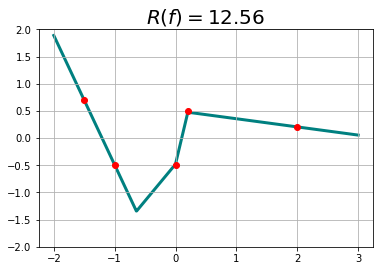

In [ ]:
x_test = torch.linspace(-2, 3, 1000).reshape(1000, 1)
y_eval_2 = sing_task_2(x_test.to('cuda:1')).detach().cpu()
plt.rc('axes', axisbelow=True)
plt.grid()
plt.scatter(xs, ys, color='red', zorder=1)
plt.plot(x_test, y_eval_2, color='teal', linewidth=3, zorder=-1)
plt.ylim([-2,2])
#plt.savefig('scalar_out_univ_fit_rand_2.pdf', dpi=500, bbox_inches='tight')
plt.show()

In [43]:
torch.save(y_eval_2, 'figs_data/univar_fig/y_eval_sing_2.pt')

In [46]:
K = 10
torch.manual_seed(60)
sing_task_3 = shallow_net(1, K, 1).to('cuda:1')

lr = 5e-3
lam = 1e-5

epochs=150000

loss_arr_sing_3, pn_arr_sing_3, sparsity_neurons_sing_3 = train_net(sing_task_3, epochs, \
                                                              xs.to('cuda:1'), ys.to('cuda:1'), lr, lam)

Epoch [1/150000], Loss: 3.712e-01, PN: 0.697,WD: 1.52,Sparse Prime: 10
Epoch [101/150000], Loss: 2.307e-01, PN: 0.714,WD: 1.46,Sparse Prime: 8
Epoch [201/150000], Loss: 2.041e-01, PN: 0.935,WD: 1.80,Sparse Prime: 8
Epoch [301/150000], Loss: 1.351e-01, PN: 2.317,WD: 3.43,Sparse Prime: 8
Epoch [401/150000], Loss: 5.595e-02, PN: 5.447,WD: 7.27,Sparse Prime: 8
Epoch [501/150000], Loss: 1.806e-02, PN: 8.660,WD: 11.76,Sparse Prime: 8
Epoch [601/150000], Loss: 2.885e-03, PN: 11.202,WD: 15.22,Sparse Prime: 8
Epoch [701/150000], Loss: 2.182e-04, PN: 12.449,WD: 16.86,Sparse Prime: 8
Epoch [801/150000], Loss: 9.956e-06, PN: 12.820,WD: 17.34,Sparse Prime: 8
Epoch [901/150000], Loss: 4.668e-07, PN: 12.898,WD: 17.44,Sparse Prime: 8
Epoch [1001/150000], Loss: 7.598e-08, PN: 12.911,WD: 17.45,Sparse Prime: 8
Epoch [1101/150000], Loss: 4.925e-08, PN: 12.913,WD: 17.44,Sparse Prime: 8
Epoch [1201/150000], Loss: 4.660e-08, PN: 12.913,WD: 17.43,Sparse Prime: 8
Epoch [1301/150000], Loss: 4.674e-08, PN: 12.91

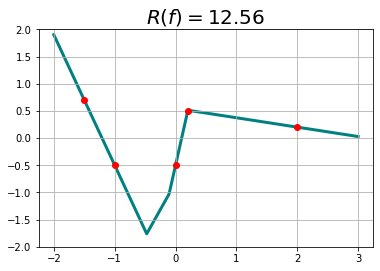

In [ ]:
x_test = torch.linspace(-2, 3, 1000).reshape(1000, 1)
y_eval_3 = sing_task_3(x_test.to('cuda:1')).detach().cpu()
plt.grid()
plt.scatter(xs, ys, color='red', zorder=1)
plt.plot(x_test, y_eval_3, color='teal', linewidth=3, zorder=-1)
plt.ylim([-2,2])
plt.savefig('scalar_out_univ_fit_rand_3.pdf', dpi=500, bbox_inches='tight')

plt.show()

## Train Multi-Task

In [10]:
ys_mtl = torch.cat([ys, torch.randn(5, 1)], dim=1)
ys_mtl.shape

torch.Size([5, 2])

In [23]:
K = 10
torch.manual_seed(40)
ys_mtl = torch.cat([ys, torch.randn(5, 1)], dim=1)
mtl_nn_1 = shallow_net(1, K, 2).to('cuda:1')

lr = 1e-3
lam = 1e-4

epochs = 20000

loss_arr_mtl_1, pn_arr_mtl_2, sparsity_neurons_mtl_3 = train_net(mtl_nn_1, epochs, \
                                                              xs.to('cuda:1'), ys_mtl.to('cuda:1'), lr, lam)

Epoch [1/20000], Loss: 5.057e-01, PN: 0.607,WD: 2.50,Sparse Prime: 10
Epoch [101/20000], Loss: 2.879e-01, PN: 0.572,WD: 2.48,Sparse Prime: 10
Epoch [201/20000], Loss: 2.480e-01, PN: 0.678,WD: 2.60,Sparse Prime: 10
Epoch [301/20000], Loss: 2.358e-01, PN: 0.826,WD: 2.71,Sparse Prime: 10
Epoch [401/20000], Loss: 2.231e-01, PN: 1.003,WD: 2.86,Sparse Prime: 10
Epoch [501/20000], Loss: 2.112e-01, PN: 1.225,WD: 3.08,Sparse Prime: 9
Epoch [601/20000], Loss: 1.991e-01, PN: 1.482,WD: 3.33,Sparse Prime: 9
Epoch [701/20000], Loss: 1.873e-01, PN: 1.791,WD: 3.66,Sparse Prime: 9
Epoch [801/20000], Loss: 1.758e-01, PN: 2.140,WD: 4.04,Sparse Prime: 8
Epoch [901/20000], Loss: 1.649e-01, PN: 2.515,WD: 4.47,Sparse Prime: 8
Epoch [1001/20000], Loss: 1.547e-01, PN: 2.913,WD: 4.94,Sparse Prime: 8
Epoch [1101/20000], Loss: 1.453e-01, PN: 3.327,WD: 5.45,Sparse Prime: 8
Epoch [1201/20000], Loss: 1.368e-01, PN: 3.752,WD: 6.00,Sparse Prime: 8
Epoch [1301/20000], Loss: 1.289e-01, PN: 4.187,WD: 6.57,Sparse Prime: 8

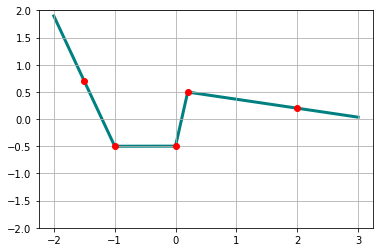

In [24]:
x_test = torch.linspace(-2, 3, 1000).reshape(1000, 1)
y_eval_mtl_1 = mtl_nn_1(x_test.to('cuda:1')).detach().cpu()[:,0]
plt.grid()
plt.scatter(xs, ys, color='red', zorder=1)
plt.plot(x_test, y_eval_mtl_1, color='teal', linewidth=3, zorder=-1)
plt.ylim([-2,2])
# plt.savefig('scalar_out_univ_fit_rand_3.pdf', dpi=500, bbox_inches='tight')

plt.show()